In [1]:
from glm.glmnet import ElasticNet
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('ggplot')

/Users/matthewdrury/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [24]:
X = np.empty(shape=(100000, 5))
X[:, 0] = 1.0
X[:, 1] = np.random.normal(loc=1.0, size=100000)
X[:, 2] = np.random.normal(scale=3.0, size=100000)
X[:, 3] = 0.1*X[:, 1] + 0.9*np.random.normal(size=100000)
X[:, 4] = -0.1*X[:, 1] + 0.9*np.random.normal(size=100000)

y = 10 - 20*X[:, 1] + 5*X[:, 2] - X[:, 4] + np.random.normal(scale=0.2, size=100000)

In [25]:
#s = StandardScaler()
#X = s.fit_transform(X)
#X[:, 0] = 1.0

In [26]:
enet = ElasticNet(lam=0.0, alpha=0.0)
enet.fit(X, y)

In [27]:
enet.coef_

array([  9.97766846e+00,  -1.99894957e+01,   5.00016947e+00,
        -3.86575183e-04,  -9.99718370e-01])

In [28]:
lr = LinearRegression()
lr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [29]:
lr.coef_

array([  0.00000000e+00,  -2.00008112e+01,   5.00019488e+00,
        -4.40180639e-04,  -9.99765837e-01])

In [30]:
lambdas = np.logspace(np.log10(0.000001), np.log10(50))

In [31]:
lambdas

array([  1.00000000e-06,   1.43589220e-06,   2.06178641e-06,
         2.96050303e-06,   4.25096322e-06,   6.10392494e-06,
         8.76457821e-06,   1.25849895e-05,   1.80706883e-05,
         2.59475604e-05,   3.72578996e-05,   5.34983275e-05,
         7.68178313e-05,   1.10302125e-04,   1.58381961e-04,
         2.27419422e-04,   3.26549775e-04,   4.68890276e-04,
         6.73275890e-04,   9.66751600e-04,   1.38815108e-03,
         1.99323532e-03,   2.86207105e-03,   4.10962549e-03,
         5.90097920e-03,   8.47317001e-03,   1.21665587e-02,
         1.74698668e-02,   2.50848455e-02,   3.60191341e-02,
         5.17195937e-02,   7.42637613e-02,   1.06634756e-01,
         1.53116014e-01,   2.19858091e-01,   3.15692518e-01,
         4.53300424e-01,   6.50890544e-01,   9.34608657e-01,
         1.34199728e+00,   1.92696343e+00,   2.76691176e+00,
         3.97298702e+00,   5.70478108e+00,   8.19145067e+00,
         1.17620401e+01,   1.68890217e+01,   2.42508146e+01,
         3.48215555e+01,

In [32]:
enets = []
for lam in lambdas:
    enet = ElasticNet(lam=lam, alpha=0.25)
    enet.fit(X, y)
    enets.append(enet.coef_)

In [33]:
coef_paths = np.row_stack(enets)

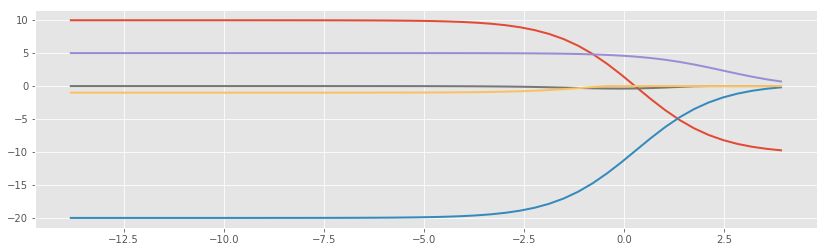

In [34]:
fig, ax = plt.subplots(figsize=(14, 4))

t = np.log(lambdas)
for idx in range(coef_paths.shape[1]):
    ax.plot(t, coef_paths[:, idx])
    